# 파생변수 제작 코드


In [17]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats

# 설정
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
# plt.rcParams['font.family'] ='Malgun Gothic' # 윈도우
plt.rcParams['font.family'] ='AppleGothic' # 맥
plt.rcParams['axes.unicode_minus'] = False

In [18]:
def make_features(df):
    """파생변수 생성 함수 - 미래 정보 제외된 버전"""
    df = df.copy()  # 원본 보존
    
    # 날짜 정리 및 정렬
    df['날짜'] = pd.to_datetime(df['날짜'])
    df = df.sort_values('날짜').reset_index(drop=True)
    
    # 6월 데이터 제거
    df = df[df["날짜"] < "2025-06-01"]

    # 시간 관련 피처
    df['월'] = df['날짜'].dt.month
    df['요일'] = df['날짜'].dt.weekday  # 0=월, ... , 6=일

    # 계절/불쾌지수등급 숫자 매핑
    season_map = {'봄': 0, '여름': 1, '가을': 2, '겨울': 3}
    discomfort_map = {'쾌적': 0, '약간 불쾌': 1, '불쾌': 2, '매우 불쾌': 3, '극심한 불쾌': 4}
    df['계절'] = df['계절'].map(season_map).astype('Int64')
    df['불쾌지수등급'] = df['불쾌지수등급'].map(discomfort_map).astype('Int64')

    # 강수량 시차 피처 (과거 데이터 사용)
    df['강수량_1일전'] = df['일_일강수량(mm)'].shift(1)
    df['강수량_2일전'] = df['일_일강수량(mm)'].shift(2)
    df['강수량_1일_누적'] = df['일_일강수량(mm)'].rolling(1, min_periods=1).sum()
    df['강수량_2일_누적'] = df['일_일강수량(mm)'].rolling(2, min_periods=1).sum()
    df['강수량_3일_누적'] = df['일_일강수량(mm)'].rolling(3, min_periods=1).sum()
    df['강수량_5일_누적'] = df['일_일강수량(mm)'].rolling(5, min_periods=1).sum()
    df['강수량_7일_누적'] = df['일_일강수량(mm)'].rolling(7, min_periods=1).sum()

    # 온도/날씨 관련 피처
    df['일교차'] = df['일_최고기온(°C)'] - df['일_최저기온(°C)'] 
    df['폭우_여부'] = (df['일_일강수량(mm)'] >= 80).astype(int)
    
    # 체감온도 계산
    if '일_평균기온(°C)' in df.columns:
        T = pd.to_numeric(df['일_평균기온(°C)'], errors='coerce')
    else:
        T = pd.Series(np.nan, index=df.index)
    if '일_평균풍속(m/s)' in df.columns:
        V_ms = pd.to_numeric(df['일_평균풍속(m/s)'], errors='coerce')
    else:
        V_ms = pd.Series(np.nan, index=df.index)
    if '평균습도(%)' in df.columns:
        RH = pd.to_numeric(df['평균습도(%)'], errors='coerce')
    else:
        RH = pd.Series(np.nan, index=df.index)

    # 윈드칠 (추위 체감)
    V_kmh = V_ms * 3.6
    wct_raw = 13.12 + 0.6215*T - 11.37*np.power(V_kmh, 0.16) + 0.3965*T*np.power(V_kmh, 0.16)
    wc_valid = (T <= 10.0) & (V_kmh >= 4.8)
    wct = T.copy()
    wct[wc_valid] = wct_raw[wc_valid]

    # 열지수 (더위 체감)
    T_f = T * 9/5 + 32
    HI_f = (-42.379 + 2.04901523*T_f + 10.14333127*RH
            - 0.22475541*T_f*RH - 0.00683783*T_f**2 - 0.05481717*RH**2
            + 0.00122874*T_f**2*RH + 0.00085282*T_f*RH**2
            - 0.00000199*T_f**2*RH**2)
    
    # 저습 보정
    mask_low = (RH < 13) & (T_f >= 80) & (T_f <= 112)
    adj_low = ((13 - RH)/4) * np.sqrt((17 - np.abs(T_f - 95))/17)
    HI_f = HI_f.where(~mask_low, HI_f - adj_low)
    
    # 고습 보정
    mask_high = (RH > 85) & (T_f >= 80) & (T_f <= 87)
    adj_high = ((RH - 85)/10) * ((87 - T_f)/5)
    HI_f = HI_f.where(~mask_high, HI_f + adj_high)
    
    hi_valid = (T_f >= 80) & (RH >= 40)
    HI_c = (HI_f - 32) * 5/9
    hi = T.copy()
    hi[hi_valid] = HI_c[hi_valid]

    # Steadman 체감온도
    e = (RH/100.0) * 6.105 * np.exp(17.27*T/(237.7 + T))
    at = T + 0.33*e - 0.70*V_ms - 4.00

    # 최종 체감온도 (윈드칠 > 열지수 > Steadman 순서)
    apparent = at.copy()
    apparent[hi_valid] = hi[hi_valid]
    apparent[wc_valid] = wct[wc_valid]
    df['체감온도(°C)'] = apparent
    
    # 분류용 등급 계산 (0~3등급)
    q = df['합계'].dropna().quantile([0.15, 0.70, 0.90])
    q15, q70, q90 = float(q.loc[0.15]), float(q.loc[0.70]), float(q.loc[0.90])

    def categorize(x):
        if pd.isna(x):
            return np.nan
        if x < q15:
            return 0
        elif x < q70:
            return 1
        elif x < q90:
            return 2
        else:
            return 3

    df['등급'] = df['합계'].apply(categorize)
    
    # 타겟 변수 생성 (1일후, 2일후)
    df['합계_1일후'] = df['합계'].shift(-1)
    df['합계_2일후'] = df['합계'].shift(-2)
    df['등급_1일후'] = df['등급'].shift(-1).astype('Int64')
    df['등급_2일후'] = df['등급'].shift(-2).astype('Int64')
    
    # 컷 기준 저장
    df.attrs['cutoffs'] = {"q15": q15, "q70": q70, "q90": q90}

    # 결측 제거
    df = df.dropna().reset_index(drop=True)
    
    # 컷 기준 저장
    df.attrs['cutoffs'] = {"q15": q15, "q70": q70, "q90": q90}

    # 결측 제거
    df = df.dropna().reset_index(drop=True)
    
    return df

In [19]:
# 디렉토리 생성
import os
os.makedirs('../data/add_feature', exist_ok=True)

# 원본 데이터 로드
nanji = pd.read_csv('../data/processed/center_season/nanji/난지_merged.csv', encoding='utf-8-sig')
jungnang = pd.read_csv('../data/processed/center_season/jungnang/중랑_merged.csv', encoding='utf-8-sig')
seonam = pd.read_csv('../data/processed/center_season/seonam/서남_merged.csv', encoding='utf-8-sig')
tancheon = pd.read_csv('../data/processed/center_season/tancheon/탄천_merged.csv', encoding='utf-8-sig')

print("원본 데이터 정보:")
print(f"nanji: {len(nanji)}행")
print(f"jungnang: {len(jungnang)}행") 
print(f"seonam: {len(seonam)}행")
print(f"tancheon: {len(tancheon)}행")

# 파생변수 생성
nanji_processed = make_features(nanji)
jungnang_processed = make_features(jungnang)
seonam_processed = make_features(seonam)
tancheon_processed = make_features(tancheon)

print("\n파생변수 생성 후:")
print(f"nanji: {len(nanji_processed)}행, {len(nanji_processed.columns)}컬럼")
print(f"jungnang: {len(jungnang_processed)}행, {len(jungnang_processed.columns)}컬럼")
print(f"seonam: {len(seonam_processed)}행, {len(seonam_processed.columns)}컬럼")
print(f"tancheon: {len(tancheon_processed)}행, {len(tancheon_processed.columns)}컬럼")

# 등급 분포 확인
print("\n등급 분포:")
for name, data in [('nanji', nanji_processed), ('jungnang', jungnang_processed), 
                   ('seonam', seonam_processed), ('tancheon', tancheon_processed)]:
    grade_dist = data['등급'].value_counts().sort_index()
    print(f"{name}: {dict(grade_dist)}")
    print(f"  컷 기준: {data.attrs['cutoffs']}")

# 파생변수 포함 데이터 저장
print("\n파일 저장 중...")
nanji_processed.to_csv('../data/add_feature/nanji_add_feature.csv', index=False, encoding='utf-8-sig')
jungnang_processed.to_csv('../data/add_feature/jungnang_add_feature.csv', index=False, encoding='utf-8-sig')
seonam_processed.to_csv('../data/add_feature/seonam_add_feature.csv', index=False, encoding='utf-8-sig')
tancheon_processed.to_csv('../data/add_feature/tancheon_add_feature.csv', index=False, encoding='utf-8-sig')

# 생성된 컬럼 확인
print(f"\n생성된 컬럼 목록 (총 {len(nanji_processed.columns)}개):")
print(list(nanji_processed.columns))

원본 데이터 정보:
nanji: 3103행
jungnang: 3103행
seonam: 3103행
tancheon: 3103행

파생변수 생성 후:
nanji: 3069행, 44컬럼
jungnang: 3069행, 44컬럼
seonam: 3069행, 43컬럼
tancheon: 3069행, 42컬럼

등급 분포:
nanji: {0: 460, 1: 1687, 2: 614, 3: 308}
  컷 기준: {'q15': 514967.96, 'q70': 597353.2, 'q90': 777950.8000000002}
jungnang: {0: 460, 1: 1687, 2: 614, 3: 308}
  컷 기준: {'q15': 1141351.6, 'q70': 1286235.0, 'q90': 1522465.0}
seonam: {0: 459, 1: 1688, 2: 614, 3: 308}
  컷 기준: {'q15': 1413894.6, 'q70': 1572508.5999999999, 'q90': 1915892.6}
tancheon: {0: 460, 1: 1687, 2: 614, 3: 308}
  컷 기준: {'q15': 661354.6, 'q70': 759833.6, 'q90': 874285.6}

파일 저장 중...

생성된 컬럼 목록 (총 44개):
['날짜', '요일', '공휴일', '목욕장업', '세탁업', '수영장업', '종합체육시설업', '체력단련장업', '하천', '생활인구', '불쾌지수(DI)', '불쾌지수등급', '일_일강수량(mm)', '일_최저기온(°C)', '일_평균기온(°C)', '일_최고기온(°C)', '일_평균풍속(m/s)', '일_최대순간풍속(m/s)', '최저습도(%)', '평균습도(%)', '최고습도(%)', '습도표준편차', '1처리장', '2처리장', '정화조', '중계펌프장', '합계', '계절', '월', '강수량_1일전', '강수량_2일전', '강수량_1일_누적', '강수량_2일_누적', '강수량_3일_누적', '강수량_5일_누적', '강수량_

In [20]:
def analyze_target_distribution(df, target_col='합계', center_name=''):
    """타깃 변수의 분포를 종합 분석"""
    
    series = pd.to_numeric(df[target_col], errors='coerce').dropna()
    print(f"=== {center_name} {target_col} 분포 분석 ===")
    print(f"데이터 개수: {len(series)}")
    print(f"결측치: {df[target_col].isna().sum()}개")
    
    # 기본 통계량
    print(f"\n기본 통계량:")
    print(f"  평균: {series.mean():.1f}")
    print(f"  표준편차: {series.std():.1f}")
    print(f"  중앙값: {series.median():.1f}")
    print(f"  최솟값: {series.min():.1f}")
    print(f"  최댓값: {series.max():.1f}")
    print(f"  범위: {series.max() - series.min():.1f}")
    
    # 분위수 정보
    quantiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
    print(f"\n분위수:")
    for q in quantiles:
        print(f"  {q*100:2.0f}%: {series.quantile(q):8.1f}")
    
    # 정규성 검정
    shapiro_stat, shapiro_p = stats.shapiro(series.sample(min(5000, len(series))))
    print(f"\n정규성 검정 (Shapiro-Wilk):")
    print(f"  통계량: {shapiro_stat:.4f}")
    print(f"  p-값: {shapiro_p:.2e}")
    print(f"  정규분포 여부: {'아니오' if shapiro_p < 0.05 else '예'}")
    
    # 왜도와 첨도
    skewness = stats.skew(series)
    kurtosis = stats.kurtosis(series)
    print(f"\n분포 형태:")
    print(f"  왜도 (Skewness): {skewness:.3f} ({'오른쪽 치우침' if skewness > 0.5 else '왼쪽 치우침' if skewness < -0.5 else '대칭적'})")
    print(f"  첨도 (Kurtosis): {kurtosis:.3f} ({'뾰족함' if kurtosis > 0 else '평평함'})")
    
    # 이상치 분석
    Q1, Q3 = series.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR
    outliers = series[(series < lower_fence) | (series > upper_fence)]
    
    print(f"\n이상치 분석 (IQR 방법):")
    print(f"  IQR: {IQR:.1f}")
    print(f"  하한: {lower_fence:.1f}")
    print(f"  상한: {upper_fence:.1f}")
    print(f"  이상치 개수: {len(outliers)}개 ({len(outliers)/len(series)*100:.1f}%)")
    if len(outliers) > 0:
        print(f"  이상치 범위: {outliers.min():.1f} ~ {outliers.max():.1f}")
    
    return {
        'series': series,
        'stats': {
            'mean': series.mean(),
            'std': series.std(),
            'median': series.median(),
            'min': series.min(),
            'max': series.max(),
            'skewness': skewness,
            'kurtosis': kurtosis,
            'outlier_count': len(outliers),
            'outlier_ratio': len(outliers)/len(series)
        }
    }

def plot_target_distribution(df, target_col='합계', center_name=''):
    """타깃 변수 분포 시각화"""
    
    series = pd.to_numeric(df[target_col], errors='coerce').dropna()
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{center_name} {target_col} 분포 분석', fontsize=16)
    
    # 1. 히스토그램
    axes[0,0].hist(series, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].axvline(series.mean(), color='red', linestyle='--', label=f'평균: {series.mean():.1f}')
    axes[0,0].axvline(series.median(), color='orange', linestyle='--', label=f'중앙값: {series.median():.1f}')
    axes[0,0].set_title('히스토그램')
    axes[0,0].set_xlabel(target_col)
    axes[0,0].set_ylabel('빈도')
    axes[0,0].legend()
    
    # 2. 박스플롯
    axes[0,1].boxplot(series, patch_artist=True)
    axes[0,1].set_title('박스플롯')
    axes[0,1].set_ylabel(target_col)
    
    # 3. Q-Q plot (정규분포와 비교)
    stats.probplot(series, dist="norm", plot=axes[0,2])
    axes[0,2].set_title('Q-Q Plot (정규분포 비교)')
    
    # 4. 시계열 플롯
    if '날짜' in df.columns:
        df_plot = df.copy()
        df_plot['날짜'] = pd.to_datetime(df_plot['날짜'])
        df_plot = df_plot.sort_values('날짜')
        axes[1,0].plot(df_plot['날짜'], df_plot[target_col], alpha=0.7)
        axes[1,0].set_title('시계열 변화')
        axes[1,0].set_xlabel('날짜')
        axes[1,0].set_ylabel(target_col)
        axes[1,0].tick_params(axis='x', rotation=45)
    
    # 5. 밀도 플롯
    axes[1,1].hist(series, bins=50, density=True, alpha=0.7, color='lightgreen', label='실제 분포')
    # 정규분포 오버레이
    x = np.linspace(series.min(), series.max(), 100)
    normal_curve = stats.norm.pdf(x, series.mean(), series.std())
    axes[1,1].plot(x, normal_curve, 'r-', label='정규분포')
    axes[1,1].set_title('밀도 분포')
    axes[1,1].set_xlabel(target_col)
    axes[1,1].set_ylabel('밀도')
    axes[1,1].legend()
    
    # 6. 분위수별 구간 시각화
    quantiles = np.arange(0, 1.1, 0.1)
    q_values = [series.quantile(q) for q in quantiles]
    axes[1,2].plot(quantiles*100, q_values, 'bo-')
    axes[1,2].set_title('분위수 곡선')
    axes[1,2].set_xlabel('백분위수 (%)')
    axes[1,2].set_ylabel(target_col)
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def analyze_classification_difficulty(df, target_col='합계', q_range=range(3, 16), center_name=''):
    """여러 클래스 수에 대한 분류 난이도 분석"""
    
    series = pd.to_numeric(df[target_col], errors='coerce').dropna()
    
    results = []
    
    for q in q_range:
        try:
            # 분위수 기반 분할
            qcut = pd.qcut(series, q=q, duplicates='drop')
            
            # 실제 생성된 구간 수 (duplicates='drop' 때문에 q보다 작을 수 있음)
            actual_bins = len(qcut.cat.categories)
            
            # 클래스 분포
            class_counts = qcut.value_counts().sort_index()
            
            # 균형도 지표들
            min_count = class_counts.min()
            max_count = class_counts.max()
            balance_ratio = min_count / max_count
            cv = class_counts.std() / class_counts.mean()  # 변동계수
            
            # 엔트로피 (높을수록 균등분포)
            probs = class_counts / class_counts.sum()
            entropy = -np.sum(probs * np.log2(probs + 1e-10))
            max_entropy = np.log2(actual_bins)
            normalized_entropy = entropy / max_entropy if max_entropy > 0 else 0
            
            results.append({
                'q_requested': q,
                'q_actual': actual_bins,
                'min_samples': min_count,
                'max_samples': max_count,
                'balance_ratio': balance_ratio,
                'cv': cv,
                'entropy': entropy,
                'normalized_entropy': normalized_entropy,
                'theoretical_accuracy': 1.0 / actual_bins  # 랜덤 추측 정확도
            })
            
        except Exception as e:
            print(f"q={q} 분석 실패: {e}")
    
    results_df = pd.DataFrame(results)
    
    print(f"\n=== {center_name} 클래스 수별 분류 난이도 ===")
    print("q: 요청 클래스 수, actual: 실제 클래스 수, balance: 균형도(높을수록 좋음)")
    print("cv: 변동계수(낮을수록 균등), entropy: 정규화 엔트로피(높을수록 균등)")
    print("theor_acc: 이론적 랜덤 정확도")
    
    display_df = results_df[['q_requested', 'q_actual', 'balance_ratio', 'cv', 'normalized_entropy', 'theoretical_accuracy']].round(3)
    display_df.columns = ['q', 'actual', 'balance', 'cv', 'entropy', 'theor_acc']
    print(display_df.to_string(index=False))
    
    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{center_name} 클래스 수별 분류 난이도 분석')
    
    # 균형도
    axes[0,0].plot(results_df['q_requested'], results_df['balance_ratio'], 'bo-')
    axes[0,0].set_title('클래스 균형도 (높을수록 좋음)')
    axes[0,0].set_xlabel('클래스 수')
    axes[0,0].set_ylabel('균형도 (min/max)')
    axes[0,0].grid(True, alpha=0.3)
    
    # 변동계수
    axes[0,1].plot(results_df['q_requested'], results_df['cv'], 'ro-')
    axes[0,1].set_title('변동계수 (낮을수록 균등)')
    axes[0,1].set_xlabel('클래스 수')
    axes[0,1].set_ylabel('변동계수')
    axes[0,1].grid(True, alpha=0.3)
    
    # 정규화 엔트로피
    axes[1,0].plot(results_df['q_requested'], results_df['normalized_entropy'], 'go-')
    axes[1,0].set_title('정규화 엔트로피 (높을수록 균등)')
    axes[1,0].set_xlabel('클래스 수')
    axes[1,0].set_ylabel('정규화 엔트로피')
    axes[1,0].grid(True, alpha=0.3)
    
    # 이론적 정확도
    axes[1,1].plot(results_df['q_requested'], results_df['theoretical_accuracy']*100, 'mo-')
    axes[1,1].set_title('이론적 랜덤 정확도')
    axes[1,1].set_xlabel('클래스 수')
    axes[1,1].set_ylabel('정확도 (%)')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 추천 클래스 수
    optimal_idx = results_df['normalized_entropy'].idxmax()
    optimal_q = results_df.loc[optimal_idx, 'q_requested']
    print(f"\n추천 클래스 수: {optimal_q}개 (엔트로피 기준)")
    
    return results_df

def comprehensive_target_analysis(centers_dict):
    """모든 센터의 타깃 변수 종합 분석"""
    
    all_stats = {}
    
    for center_name, df in centers_dict.items():
        print(f"\n{'='*60}")
        
        # 파생변수 생성 (합계_1일후 포함)
        # df_processed = make_features(df)  #위에서 이미 실행함
         
        # 원본 합계 분석
        print(f"[{center_name}] 원본 합계")
        stats_original = analyze_target_distribution(df, '합계', center_name)
        
        # 1일 후 합계 분석
        print(f"\n[{center_name}] 1일 후 합계 (예측 타깃)")
        stats_1day = analyze_target_distribution(df, '합계_1일후', center_name)
        
        all_stats[center_name] = {
            'original': stats_original['stats'],
            '1day_after': stats_1day['stats']
        }
        
        # 분포 시각화
        plot_target_distribution(df, '합계', f'{center_name} 원본')
        plot_target_distribution(df, '합계_1일후', f'{center_name} 1일후')
        
        # 분류 난이도 분석
        analyze_classification_difficulty(df, '합계_1일후', range(3, 12), f'{center_name} 1일후')
    
    # 센터 간 비교
    print(f"\n{'='*60}")
    print("=== 센터별 비교 요약 ===")
    
    comparison_df = pd.DataFrame({
        center: stats['1day_after'] 
        for center, stats in all_stats.items()
    }).T.round(2)
    
    print(comparison_df)
    
    return all_stats

# 사용 예시
if __name__ == "__main__":
    print("=== 타깃 변수 분포 분석 도구 ===")
    print("사용법:")
    print("1. 단일 센터 분석:")
    print("   stats = analyze_target_distribution(nanji, '합계', 'nanji')")
    print("   plot_target_distribution(nanji, '합계', 'nanji')")
    print("   difficulty = analyze_classification_difficulty(nanji, '합계', range(3,12), 'nanji')")
    print("2. 전체 센터 종합 분석:")
    print("   all_stats = comprehensive_target_analysis(centers_dict)")

=== 타깃 변수 분포 분석 도구 ===
사용법:
1. 단일 센터 분석:
   stats = analyze_target_distribution(nanji, '합계', 'nanji')
   plot_target_distribution(nanji, '합계', 'nanji')
   difficulty = analyze_classification_difficulty(nanji, '합계', range(3,12), 'nanji')
2. 전체 센터 종합 분석:
   all_stats = comprehensive_target_analysis(centers_dict)



[nanji] 원본 합계
=== nanji 합계 분포 분석 ===
데이터 개수: 3069
결측치: 0개

기본 통계량:
  평균: 603930.6
  표준편차: 133060.2
  중앙값: 556440.7
  최솟값: 442332.8
  최댓값: 1381444.0
  범위: 939111.2

분위수:
   5%: 498739.3
  10%: 507748.0
  25%: 527209.0
  50%: 556440.7
  75%: 617297.0
  90%: 778260.8
  95%: 893169.0
  99%: 1145035.3

정규성 검정 (Shapiro-Wilk):
  통계량: 0.7151
  p-값: 3.36e-58
  정규분포 여부: 아니오

분포 형태:
  왜도 (Skewness): 2.422 (오른쪽 치우침)
  첨도 (Kurtosis): 6.581 (뾰족함)

이상치 분석 (IQR 방법):
  IQR: 90088.0
  하한: 392077.0
  상한: 752429.0
  이상치 개수: 353개 (11.5%)
  이상치 범위: 753750.0 ~ 1381444.0

[nanji] 1일 후 합계 (예측 타깃)
=== nanji 합계_1일후 분포 분석 ===
데이터 개수: 3069
결측치: 0개

기본 통계량:
  평균: 603962.9
  표준편차: 133044.2
  중앙값: 556452.0
  최솟값: 442332.8
  최댓값: 1381444.0
  범위: 939111.2

분위수:
   5%: 498847.2
  10%: 507758.6
  25%: 527249.0
  50%: 556452.0
  75%: 617297.0
  90%: 778260.8
  95%: 893169.0
  99%: 1145035.3

정규성 검정 (Shapiro-Wilk):
  통계량: 0.7150
  p-값: 3.33e-58
  정규분포 여부: 아니오

분포 형태:
  왜도 (Skewness): 2.423 (오른쪽 치우침)
  첨도 (Kurtosis): 6.584

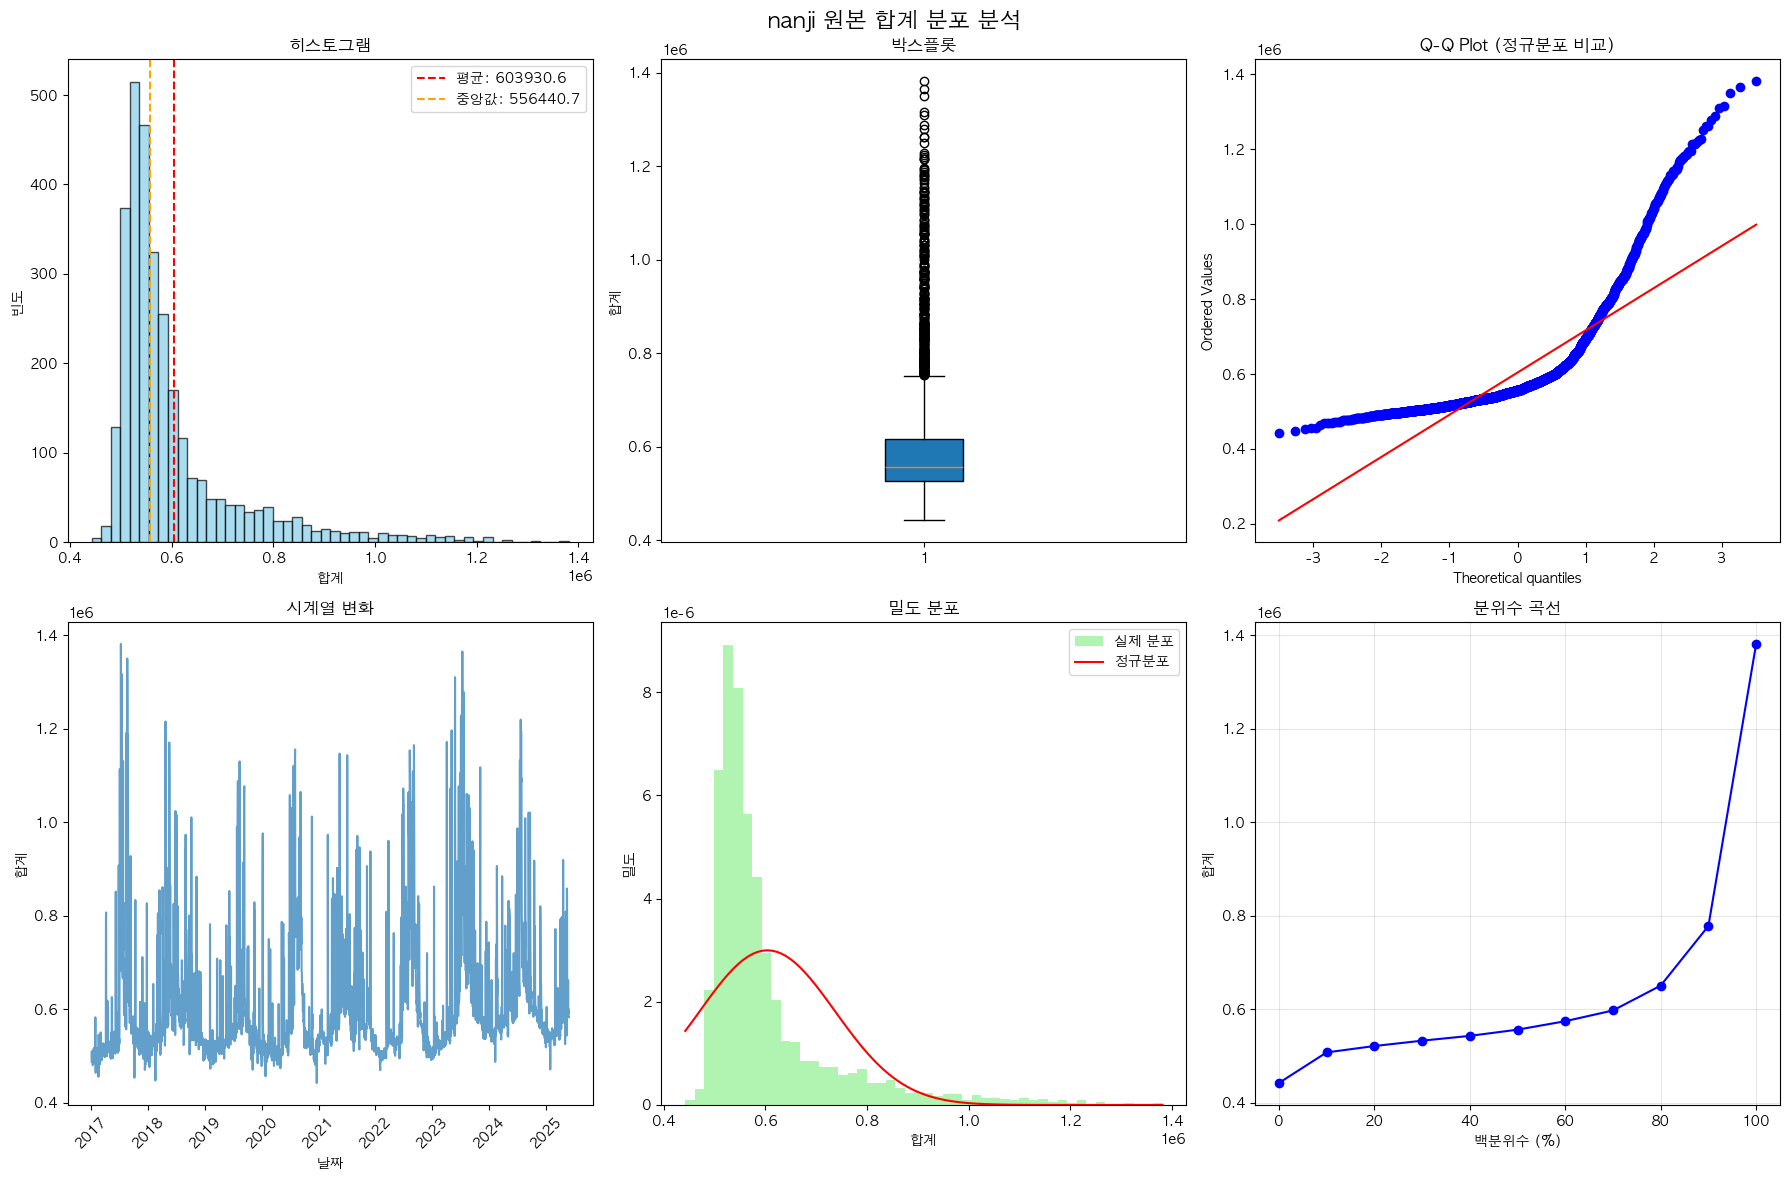

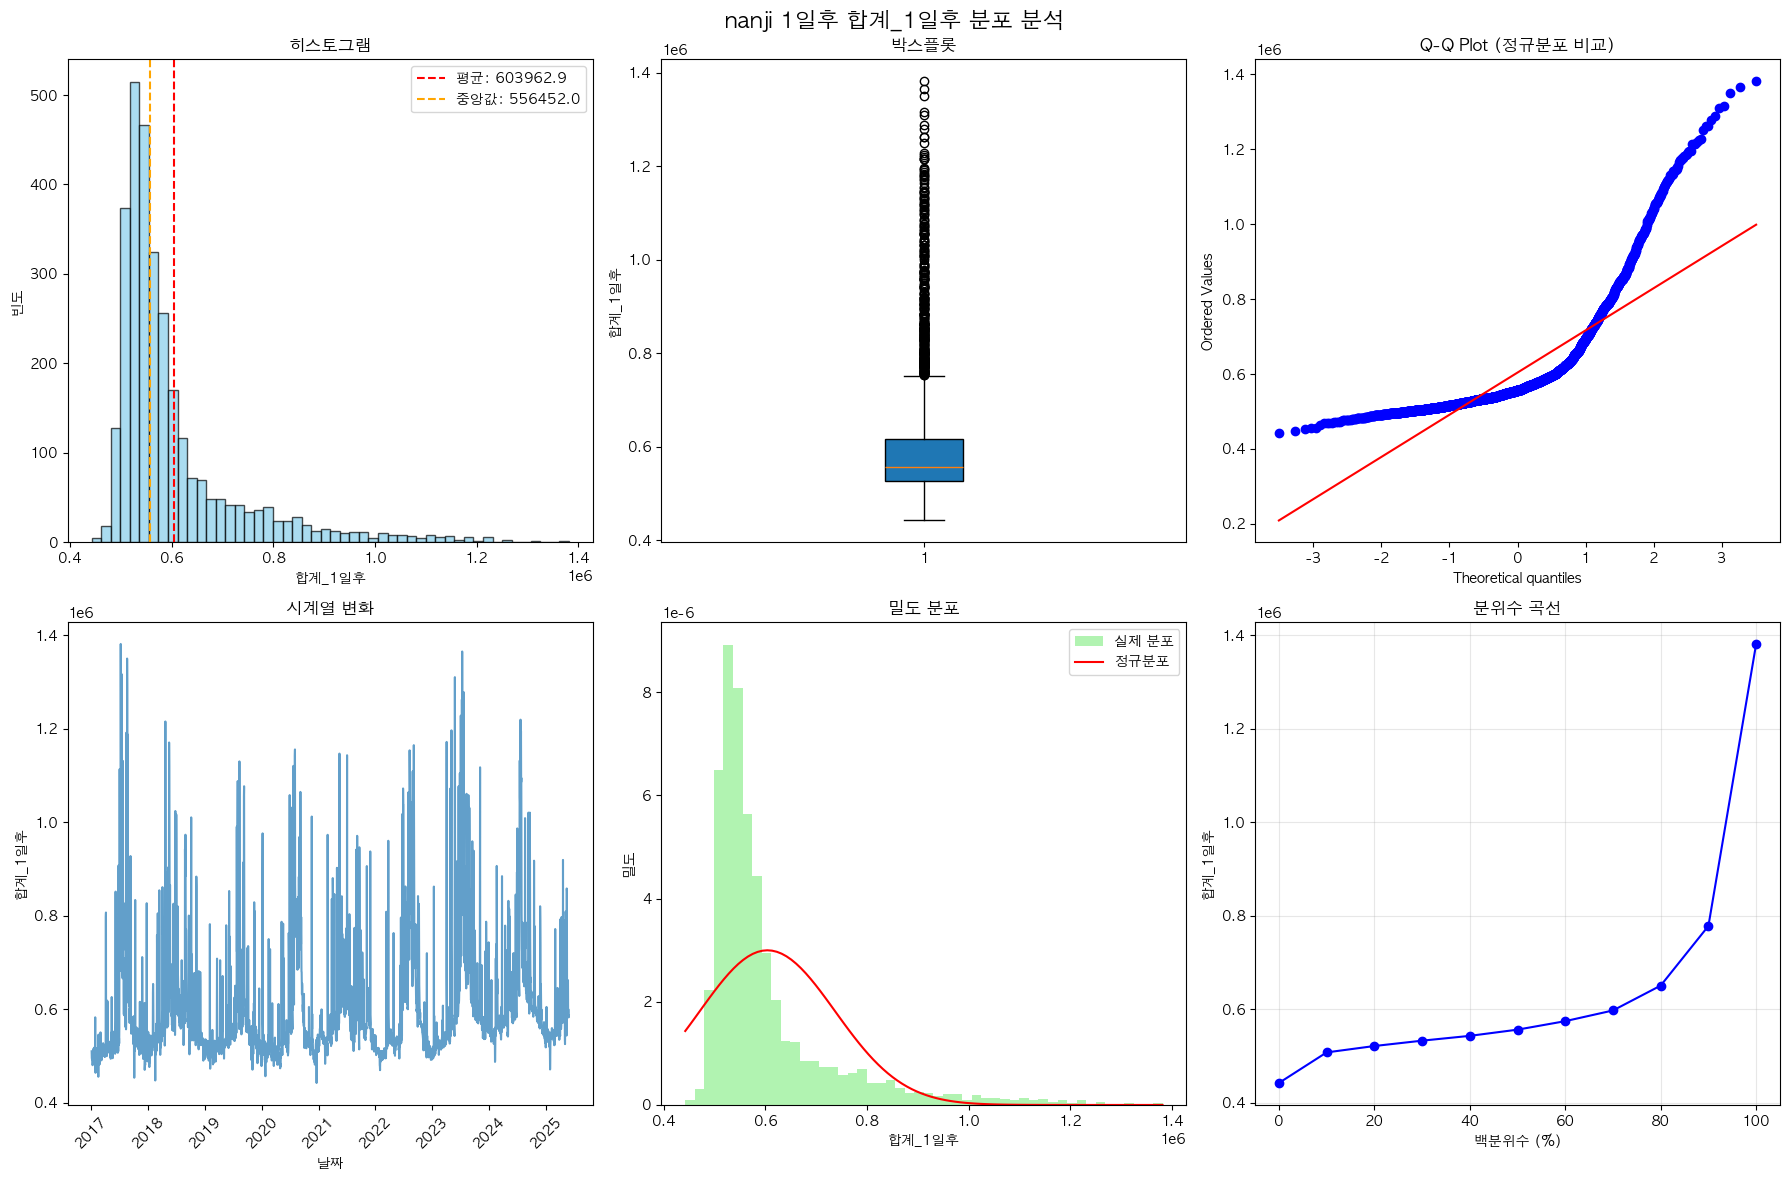


=== nanji 1일후 클래스 수별 분류 난이도 ===
q: 요청 클래스 수, actual: 실제 클래스 수, balance: 균형도(높을수록 좋음)
cv: 변동계수(낮을수록 균등), entropy: 정규화 엔트로피(높을수록 균등)
theor_acc: 이론적 랜덤 정확도
 q  actual  balance    cv  entropy  theor_acc
 3       3    1.000 0.000      1.0      0.333
 4       4    0.999 0.001      1.0      0.250
 5       5    0.998 0.001      1.0      0.200
 6       6    0.998 0.001      1.0      0.167
 7       7    0.998 0.001      1.0      0.143
 8       8    0.997 0.001      1.0      0.125
 9       9    1.000 0.000      1.0      0.111
10      10    0.997 0.001      1.0      0.100
11      11    1.000 0.000      1.0      0.091


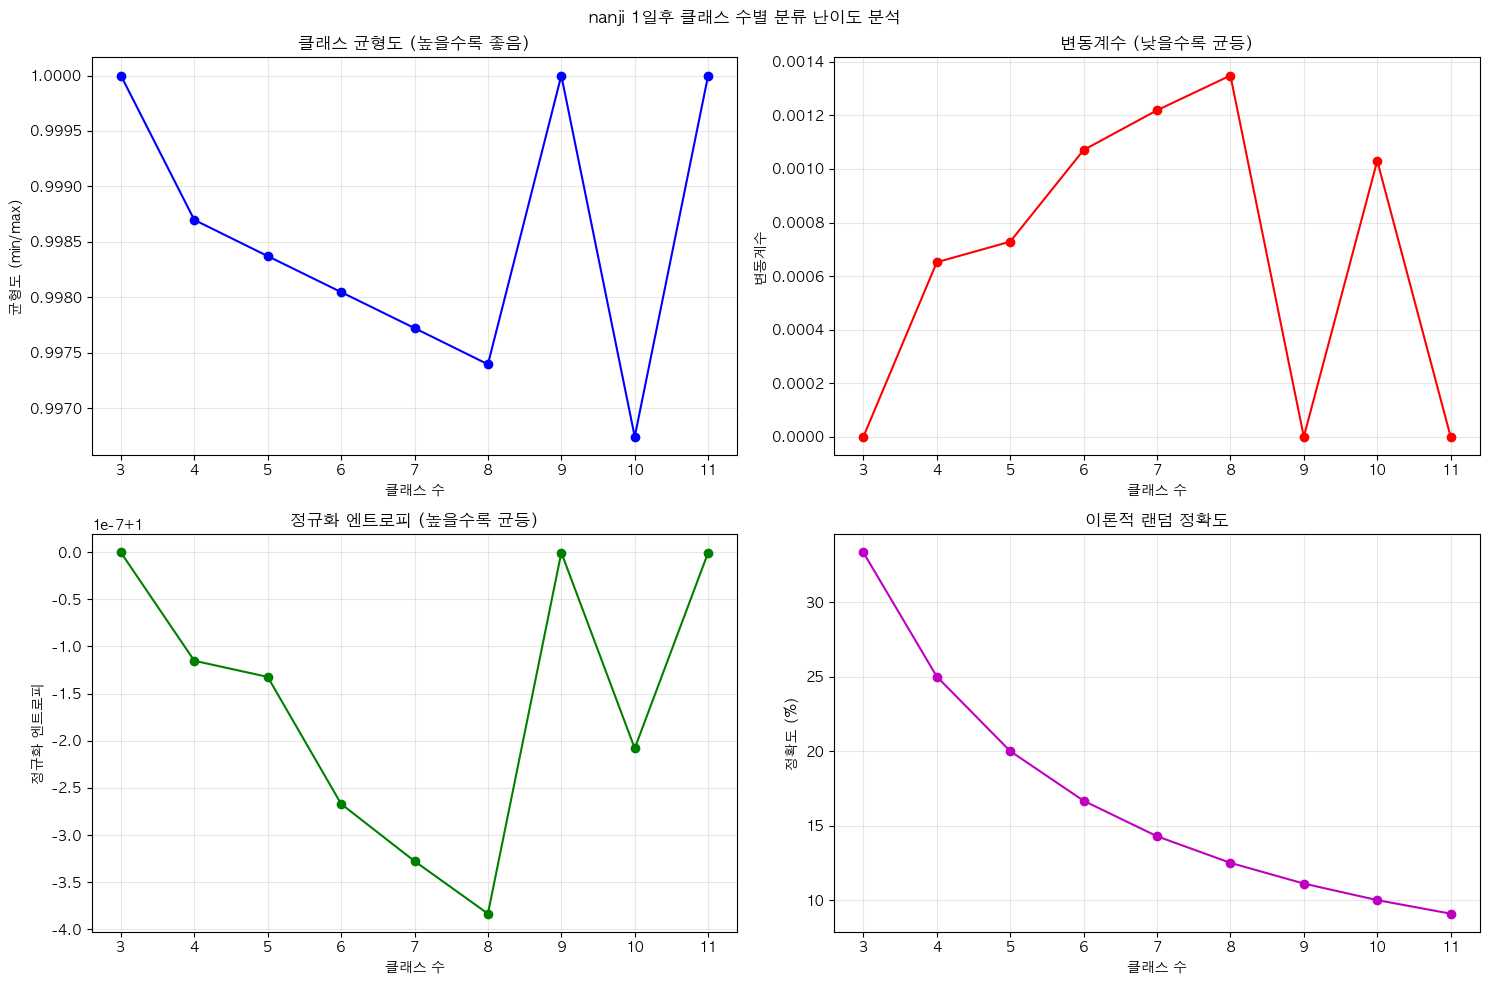


추천 클래스 수: 3개 (엔트로피 기준)

[jungnang] 원본 합계
=== jungnang 합계 분포 분석 ===
데이터 개수: 3069
결측치: 0개

기본 통계량:
  평균: 1279003.8
  표준편차: 196413.1
  중앙값: 1222238.0
  최솟값: 625472.0
  최댓값: 2745792.0
  범위: 2120320.0

분위수:
   5%: 1093140.4
  10%: 1122958.8
  25%: 1169120.0
  50%: 1222238.0
  75%: 1315939.0
  90%: 1522644.2
  95%: 1689562.2
  99%: 1994835.0

정규성 검정 (Shapiro-Wilk):
  통계량: 0.7775
  p-값: 8.06e-54
  정규분포 여부: 아니오

분포 형태:
  왜도 (Skewness): 2.409 (오른쪽 치우침)
  첨도 (Kurtosis): 8.520 (뾰족함)

이상치 분석 (IQR 방법):
  IQR: 146819.0
  하한: 948891.5
  상한: 1536167.5
  이상치 개수: 290개 (9.4%)
  이상치 범위: 625472.0 ~ 2745792.0

[jungnang] 1일 후 합계 (예측 타깃)
=== jungnang 합계_1일후 분포 분석 ===
데이터 개수: 3069
결측치: 0개

기본 통계량:
  평균: 1279005.8
  표준편차: 196412.6
  중앙값: 1222238.0
  최솟값: 625472.0
  최댓값: 2745792.0
  범위: 2120320.0

분위수:
   5%: 1093140.4
  10%: 1122958.8
  25%: 1169120.0
  50%: 1222238.0
  75%: 1315939.0
  90%: 1522644.2
  95%: 1689562.2
  99%: 1994835.0

정규성 검정 (Shapiro-Wilk):
  통계량: 0.7776
  p-값: 8.07e-54
  정규분포 여부: 아니오

분포 형태

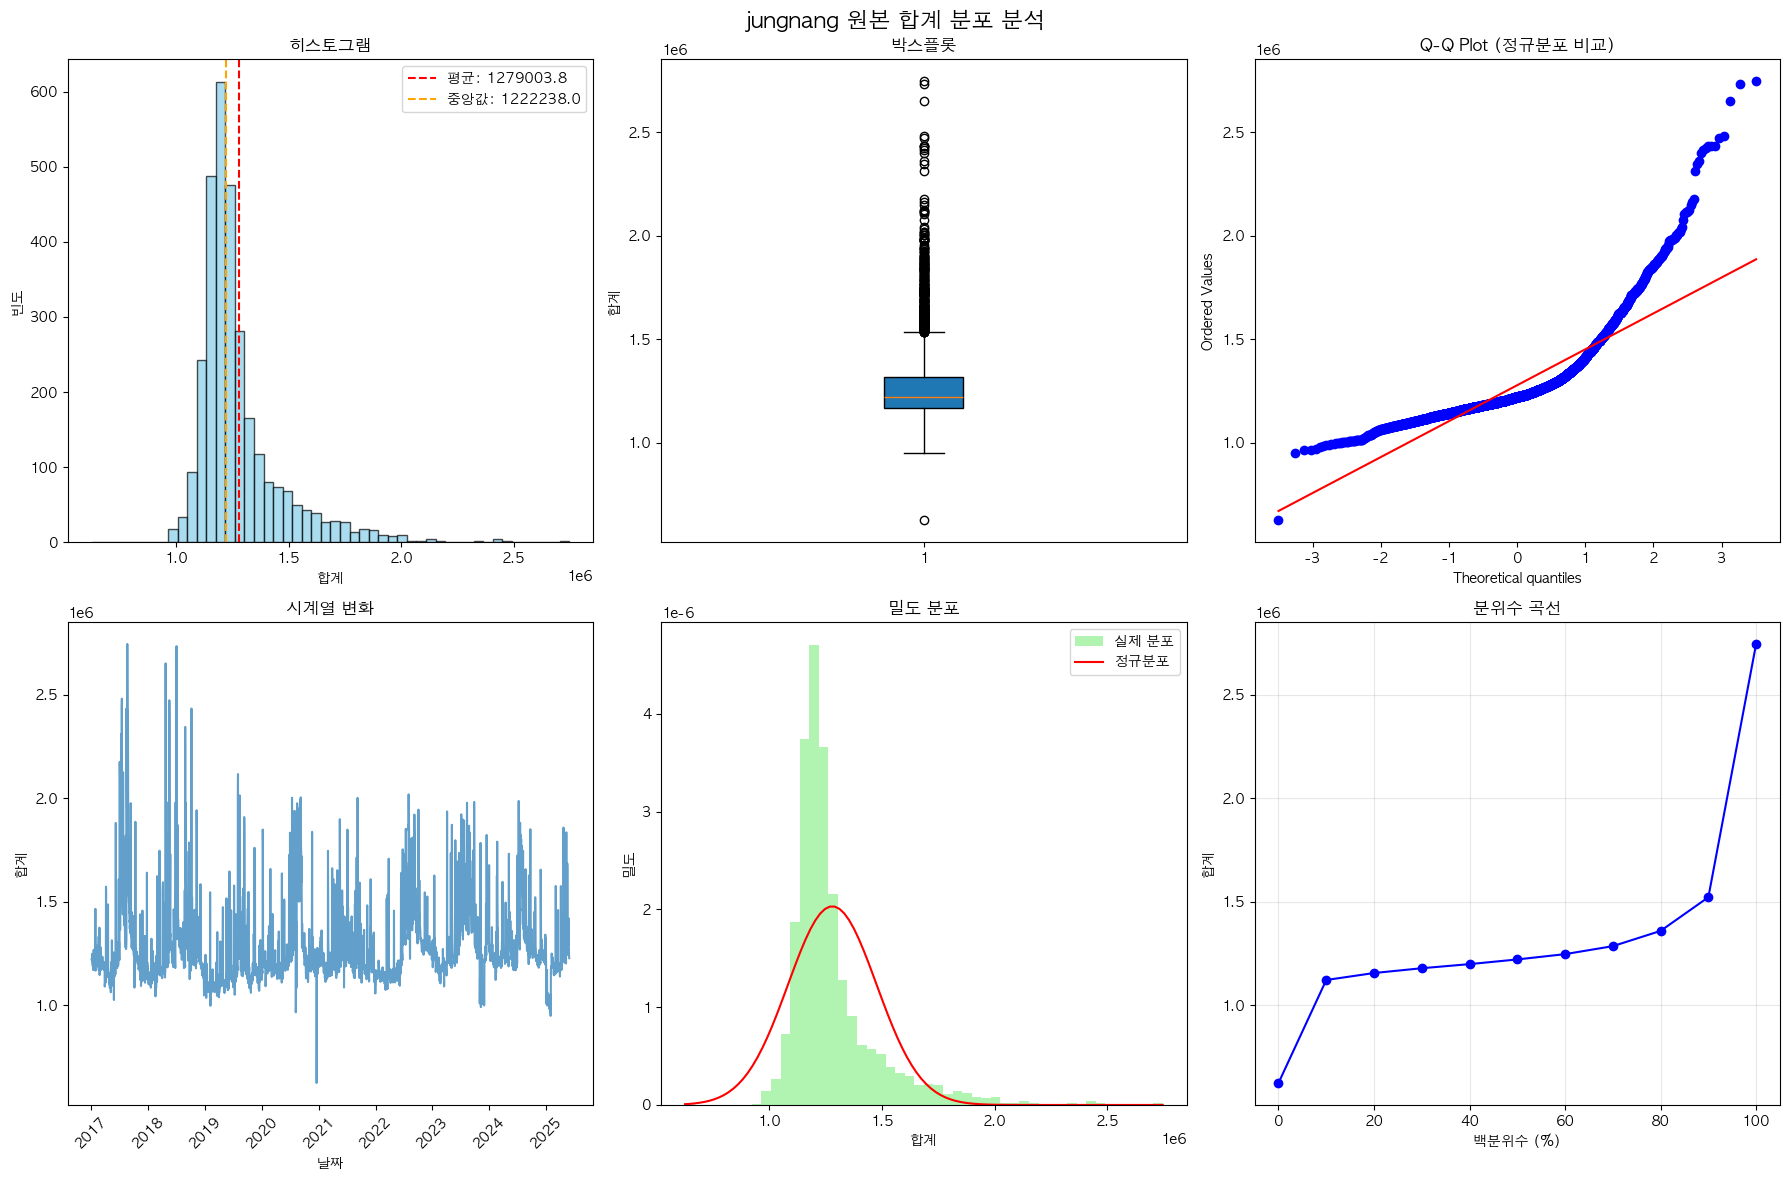

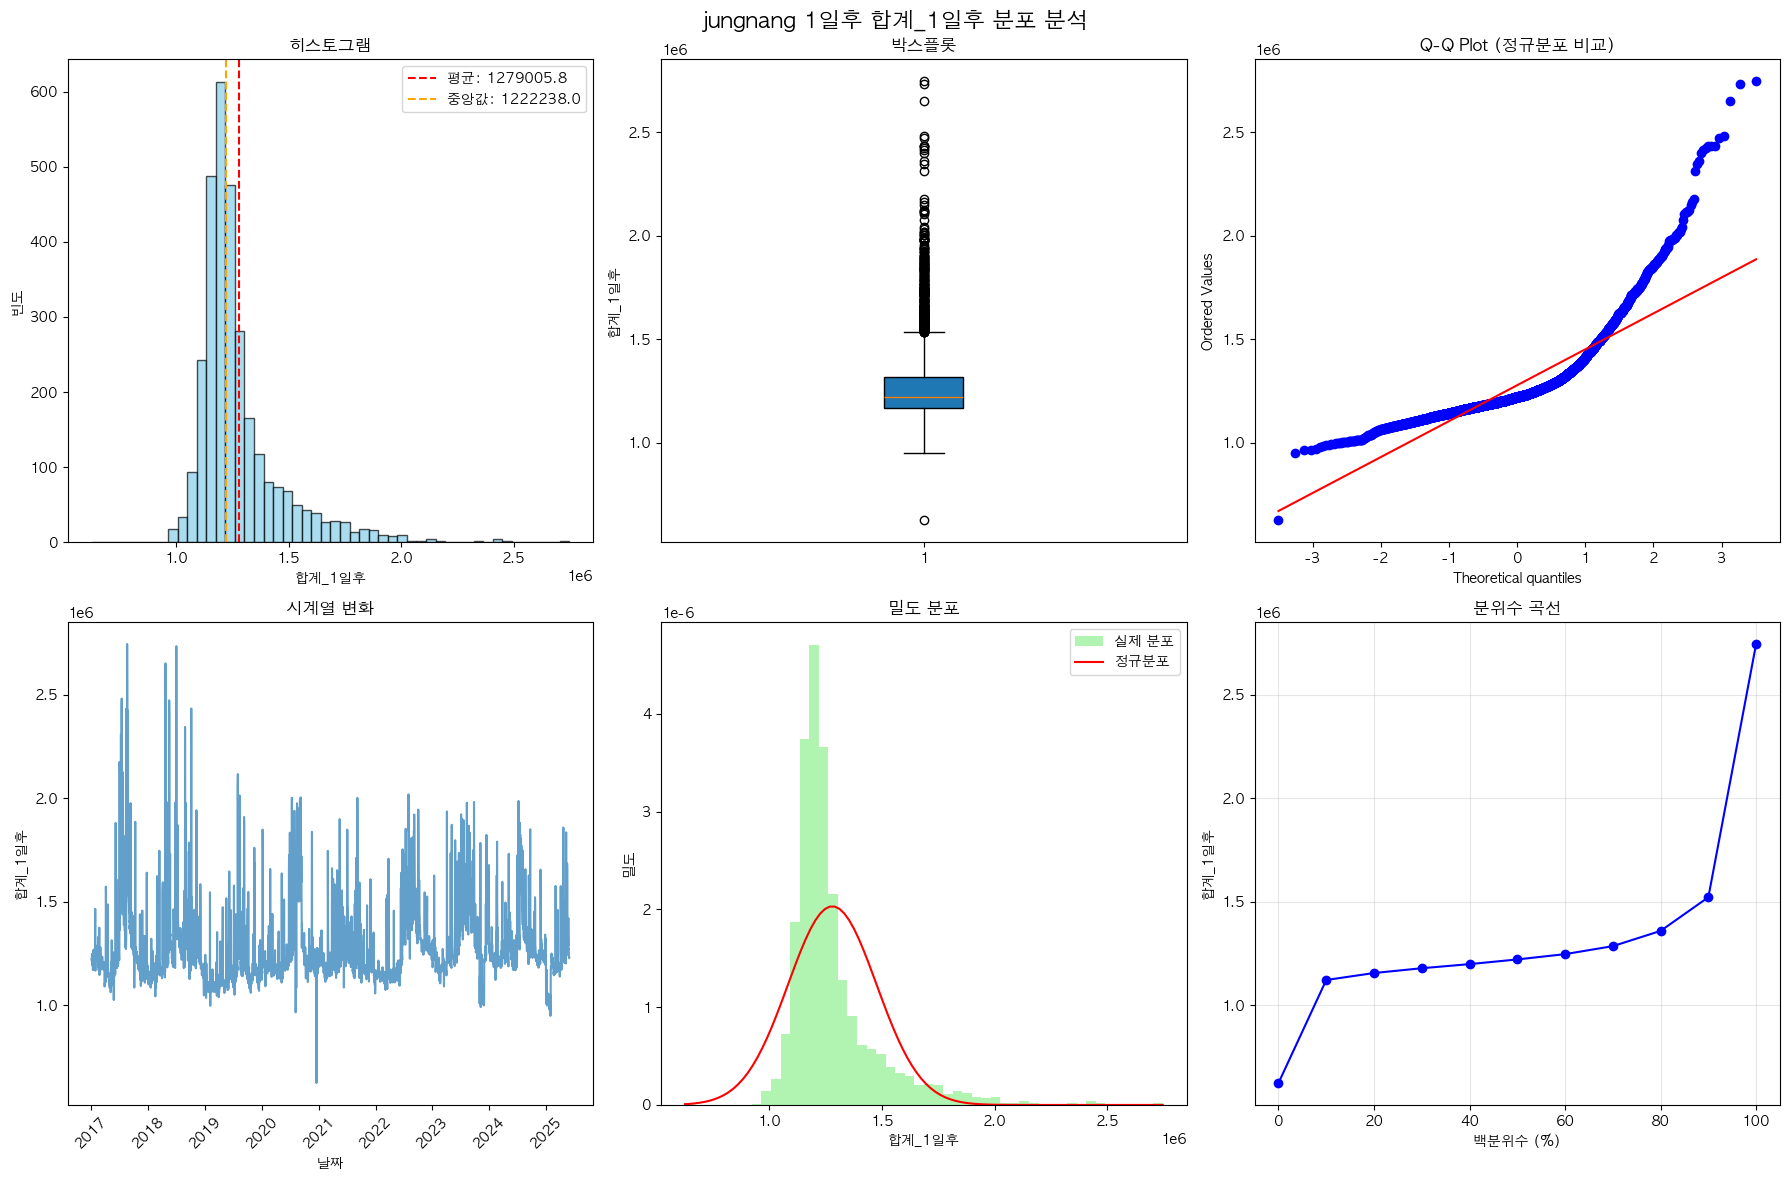


=== jungnang 1일후 클래스 수별 분류 난이도 ===
q: 요청 클래스 수, actual: 실제 클래스 수, balance: 균형도(높을수록 좋음)
cv: 변동계수(낮을수록 균등), entropy: 정규화 엔트로피(높을수록 균등)
theor_acc: 이론적 랜덤 정확도
 q  actual  balance    cv  entropy  theor_acc
 3       3    1.000 0.000      1.0      0.333
 4       4    0.999 0.001      1.0      0.250
 5       5    0.998 0.001      1.0      0.200
 6       6    0.998 0.001      1.0      0.167
 7       7    0.998 0.001      1.0      0.143
 8       8    0.997 0.001      1.0      0.125
 9       9    1.000 0.000      1.0      0.111
10      10    0.997 0.001      1.0      0.100
11      11    1.000 0.000      1.0      0.091


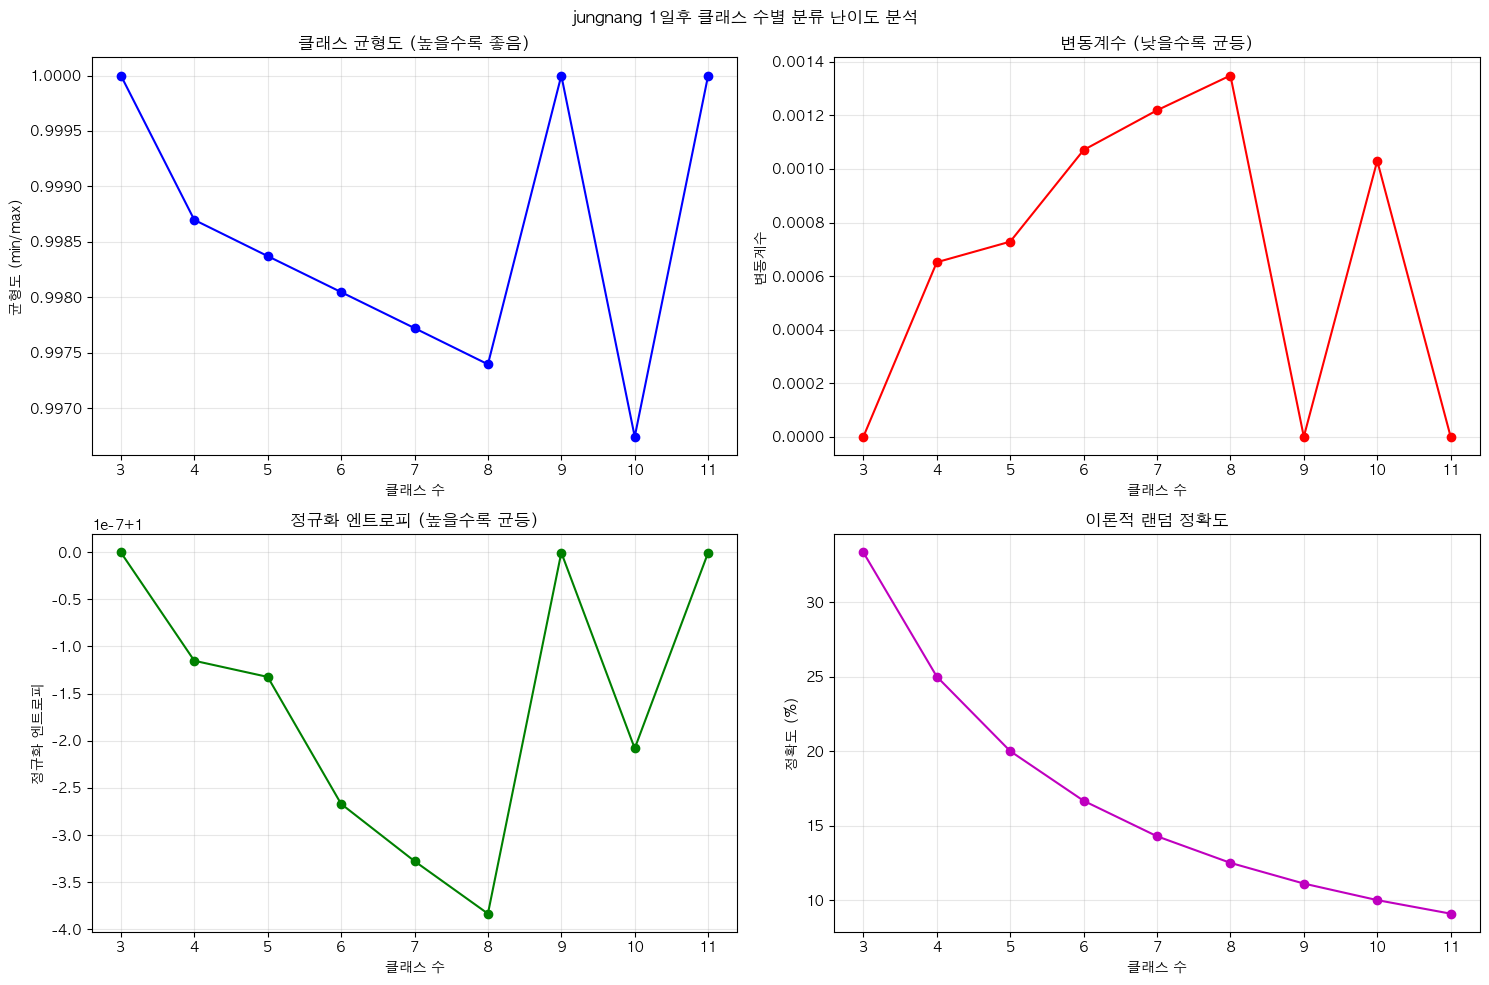


추천 클래스 수: 3개 (엔트로피 기준)

[seonam] 원본 합계
=== seonam 합계 분포 분석 ===
데이터 개수: 3069
결측치: 0개

기본 통계량:
  평균: 1576811.9
  표준편차: 238522.3
  중앙값: 1504241.0
  최솟값: 1160337.0
  최댓값: 2780034.0
  범위: 1619697.0

분위수:
   5%: 1348246.8
  10%: 1392512.4
  25%: 1446570.0
  50%: 1504241.0
  75%: 1604308.0
  90%: 1916230.0
  95%: 2131117.0
  99%: 2495830.6

정규성 검정 (Shapiro-Wilk):
  통계량: 0.7610
  p-값: 4.50e-55
  정규분포 여부: 아니오

분포 형태:
  왜도 (Skewness): 2.115 (오른쪽 치우침)
  첨도 (Kurtosis): 4.642 (뾰족함)

이상치 분석 (IQR 방법):
  IQR: 157738.0
  하한: 1209963.0
  상한: 1840915.0
  이상치 개수: 362개 (11.8%)
  이상치 범위: 1160337.0 ~ 2780034.0

[seonam] 1일 후 합계 (예측 타깃)
=== seonam 합계_1일후 분포 분석 ===
데이터 개수: 3069
결측치: 0개

기본 통계량:
  평균: 1576757.8
  표준편차: 238566.2
  중앙값: 1504241.0
  최솟값: 1160337.0
  최댓값: 2780034.0
  범위: 1619697.0

분위수:
   5%: 1348107.2
  10%: 1392348.6
  25%: 1446543.0
  50%: 1504241.0
  75%: 1604308.0
  90%: 1916230.0
  95%: 2131117.0
  99%: 2495830.6

정규성 검정 (Shapiro-Wilk):
  통계량: 0.7612
  p-값: 4.70e-55
  정규분포 여부: 아니오

분포 형태:
 

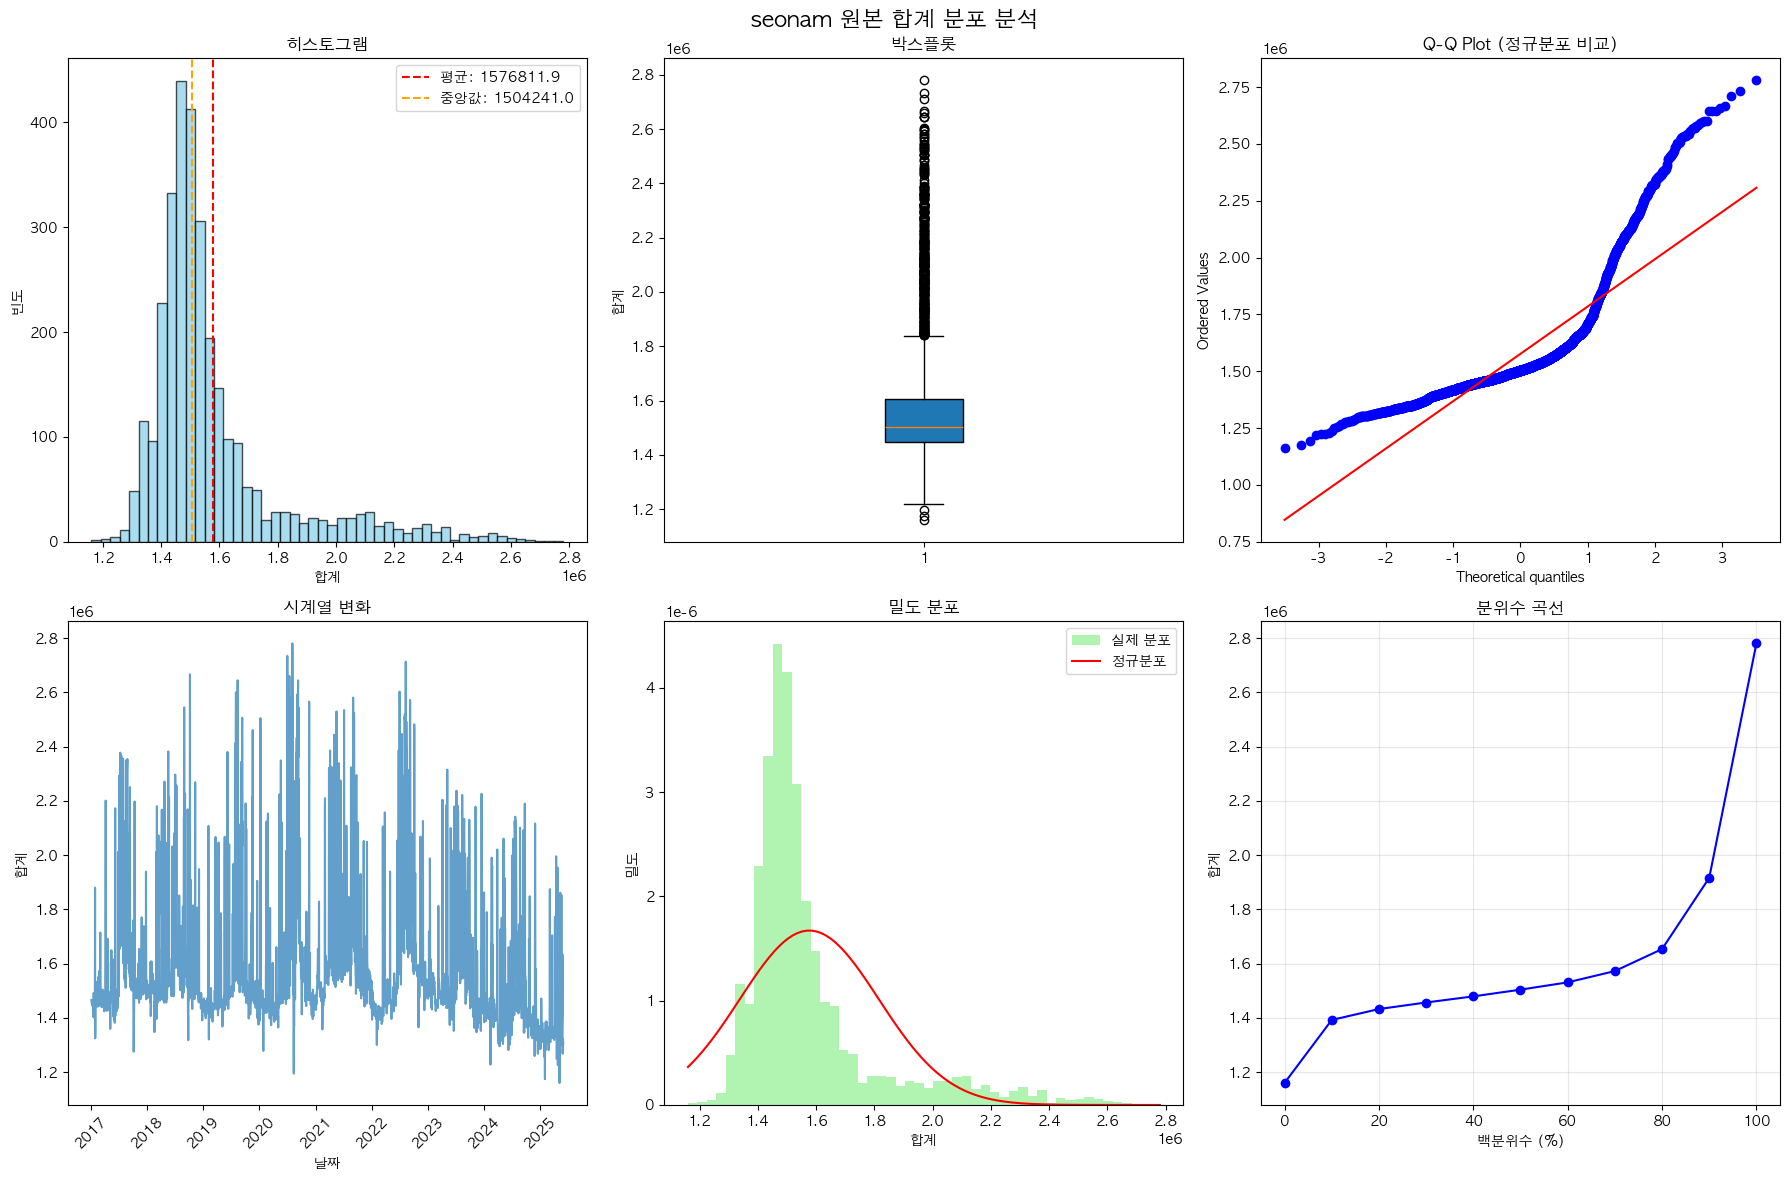

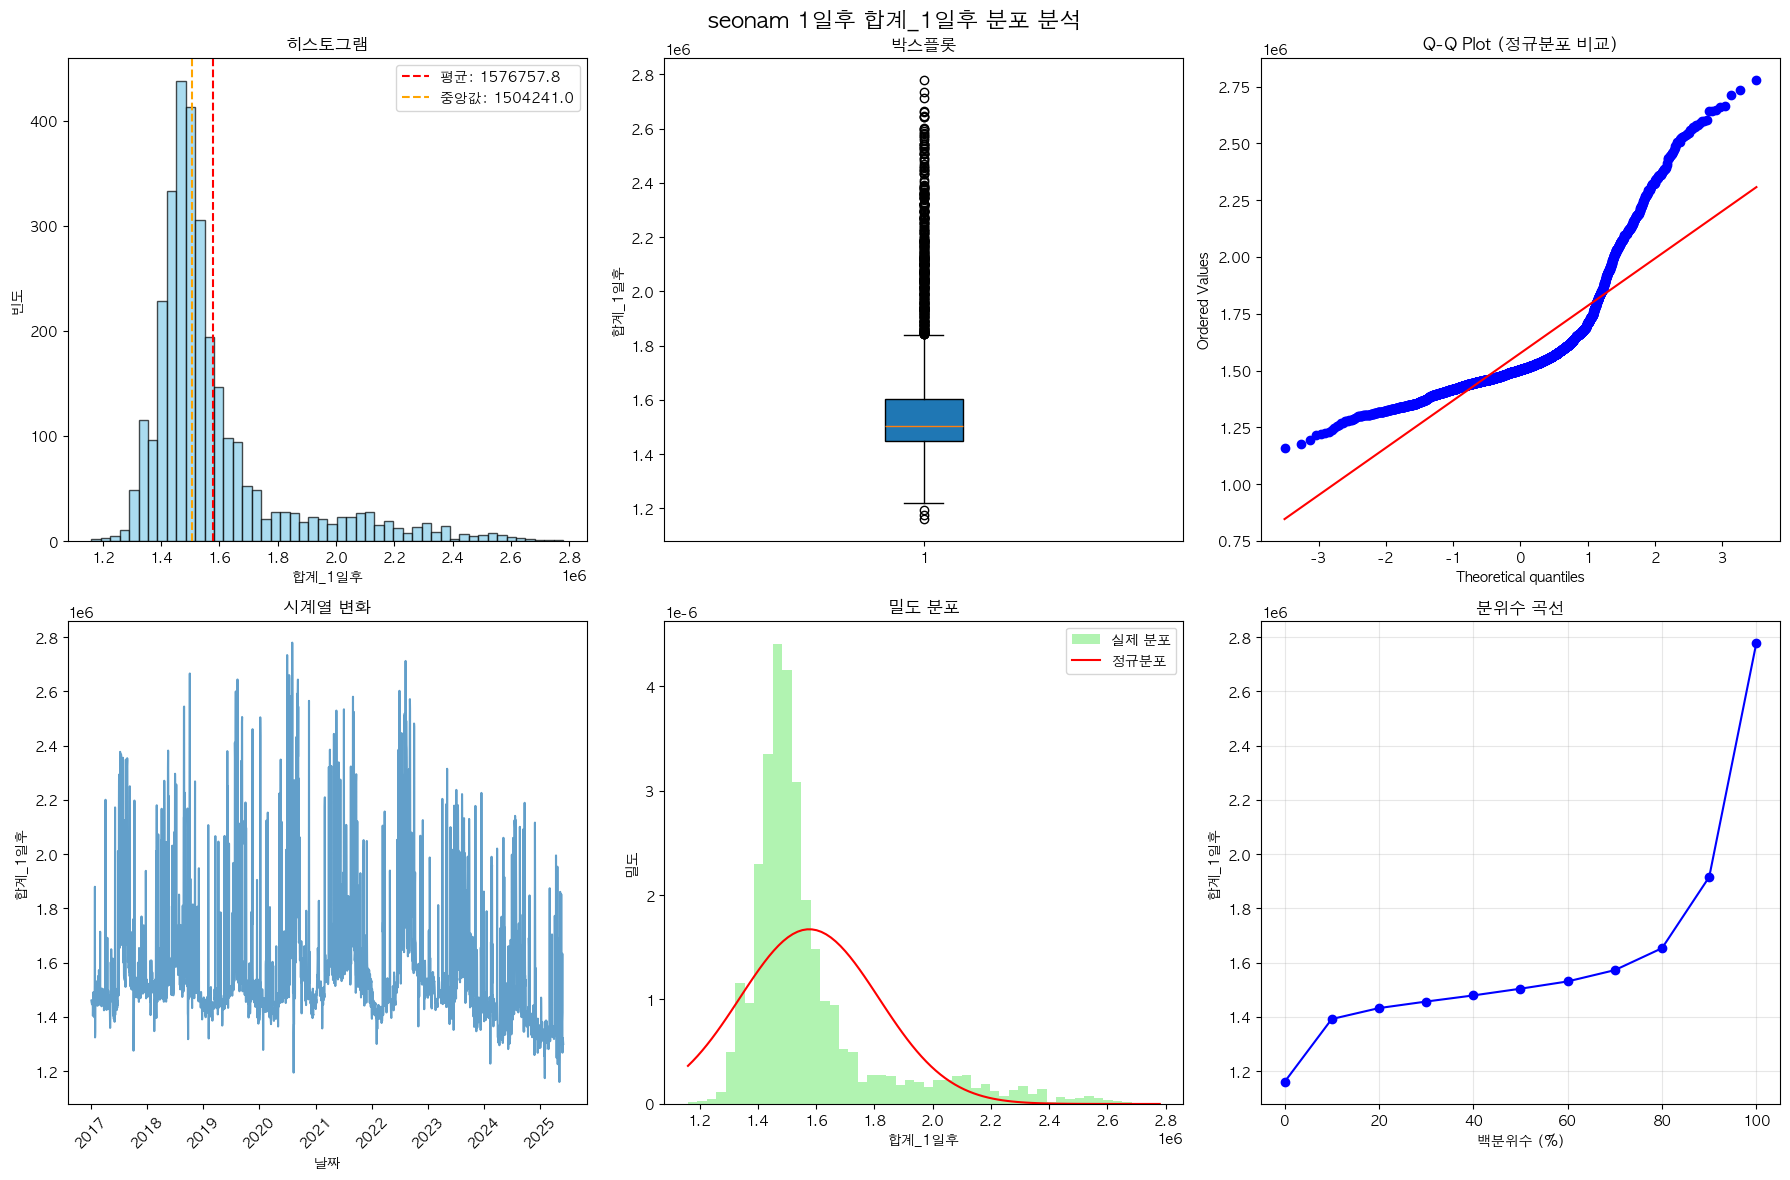


=== seonam 1일후 클래스 수별 분류 난이도 ===
q: 요청 클래스 수, actual: 실제 클래스 수, balance: 균형도(높을수록 좋음)
cv: 변동계수(낮을수록 균등), entropy: 정규화 엔트로피(높을수록 균등)
theor_acc: 이론적 랜덤 정확도
 q  actual  balance    cv  entropy  theor_acc
 3       3    1.000 0.000      1.0      0.333
 4       4    0.999 0.001      1.0      0.250
 5       5    0.998 0.001      1.0      0.200
 6       6    0.998 0.001      1.0      0.167
 7       7    0.998 0.001      1.0      0.143
 8       8    0.997 0.001      1.0      0.125
 9       9    1.000 0.000      1.0      0.111
10      10    0.997 0.001      1.0      0.100
11      11    1.000 0.000      1.0      0.091


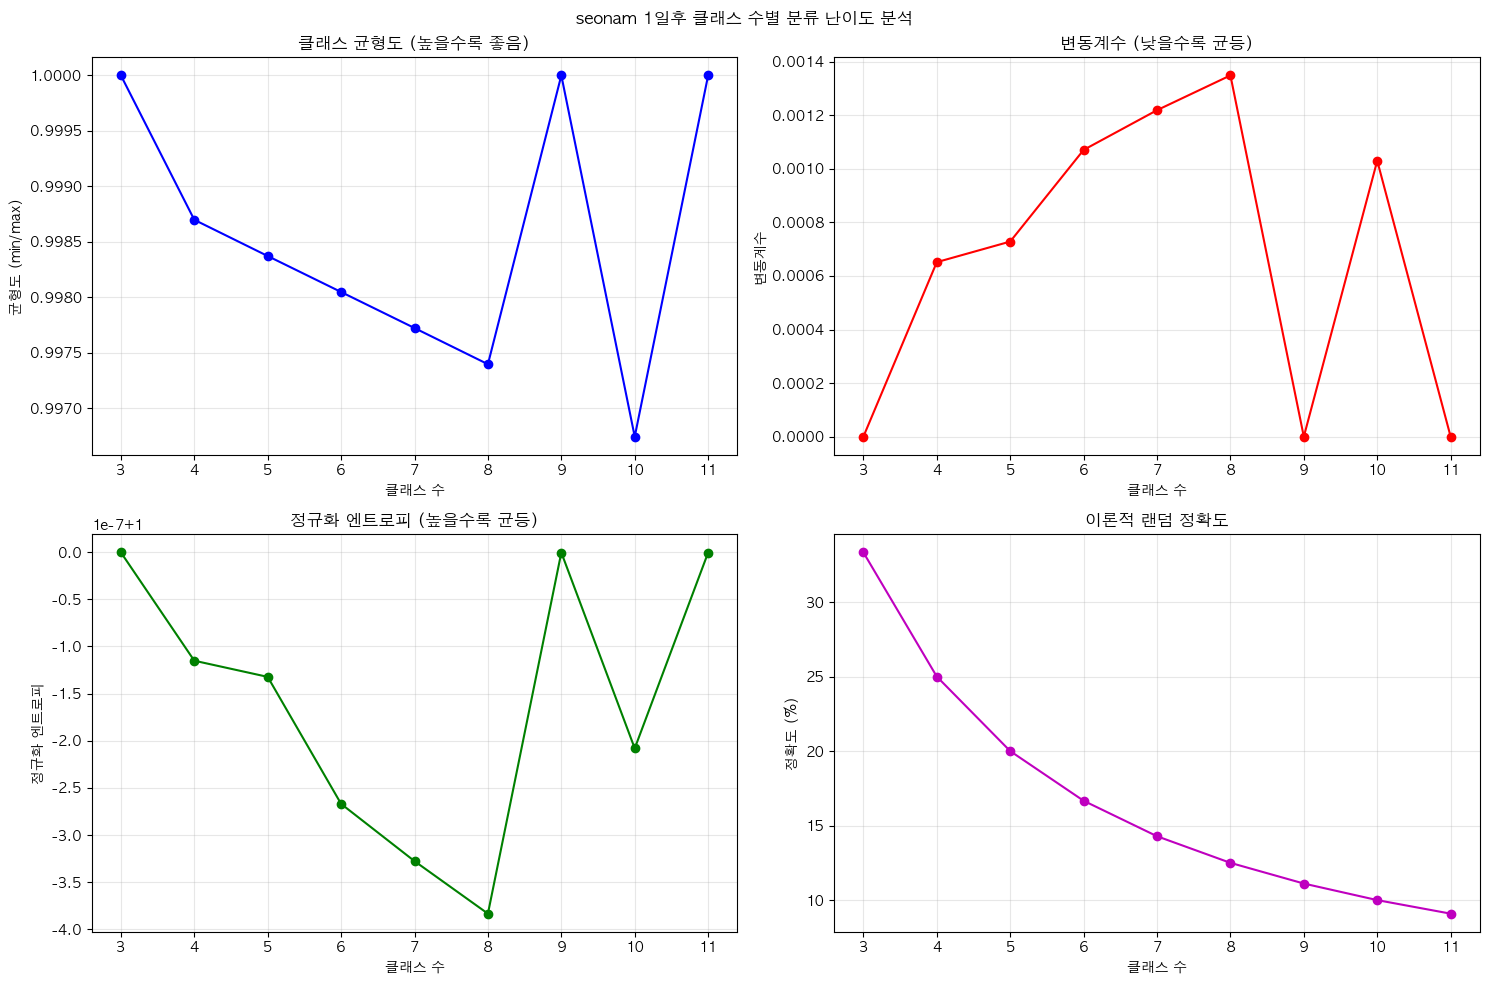


추천 클래스 수: 3개 (엔트로피 기준)

[tancheon] 원본 합계
=== tancheon 합계 분포 분석 ===
데이터 개수: 3069
결측치: 0개

기본 통계량:
  평균: 745567.1
  표준편차: 108230.8
  중앙값: 718297.0
  최솟값: 543425.0
  최댓값: 1423827.0
  범위: 880402.0

분위수:
   5%: 639631.8
  10%: 651956.4
  25%: 677393.0
  50%: 718297.0
  75%: 776784.0
  90%: 874332.0
  95%: 969938.4
  99%: 1179709.6

정규성 검정 (Shapiro-Wilk):
  통계량: 0.8093
  p-값: 3.47e-51
  정규분포 여부: 아니오

분포 형태:
  왜도 (Skewness): 2.150 (오른쪽 치우침)
  첨도 (Kurtosis): 6.185 (뾰족함)

이상치 분석 (IQR 방법):
  IQR: 99391.0
  하한: 528306.5
  상한: 925870.5
  이상치 개수: 193개 (6.3%)
  이상치 범위: 926100.0 ~ 1423827.0

[tancheon] 1일 후 합계 (예측 타깃)
=== tancheon 합계_1일후 분포 분석 ===
데이터 개수: 3069
결측치: 0개

기본 통계량:
  평균: 745572.5
  표준편차: 108227.7
  중앙값: 718297.0
  최솟값: 543425.0
  최댓값: 1423827.0
  범위: 880402.0

분위수:
   5%: 639631.8
  10%: 651956.4
  25%: 677407.0
  50%: 718297.0
  75%: 776784.0
  90%: 874332.0
  95%: 969938.4
  99%: 1179709.6

정규성 검정 (Shapiro-Wilk):
  통계량: 0.8093
  p-값: 3.47e-51
  정규분포 여부: 아니오

분포 형태:
  왜도 (Skewness): 2.1

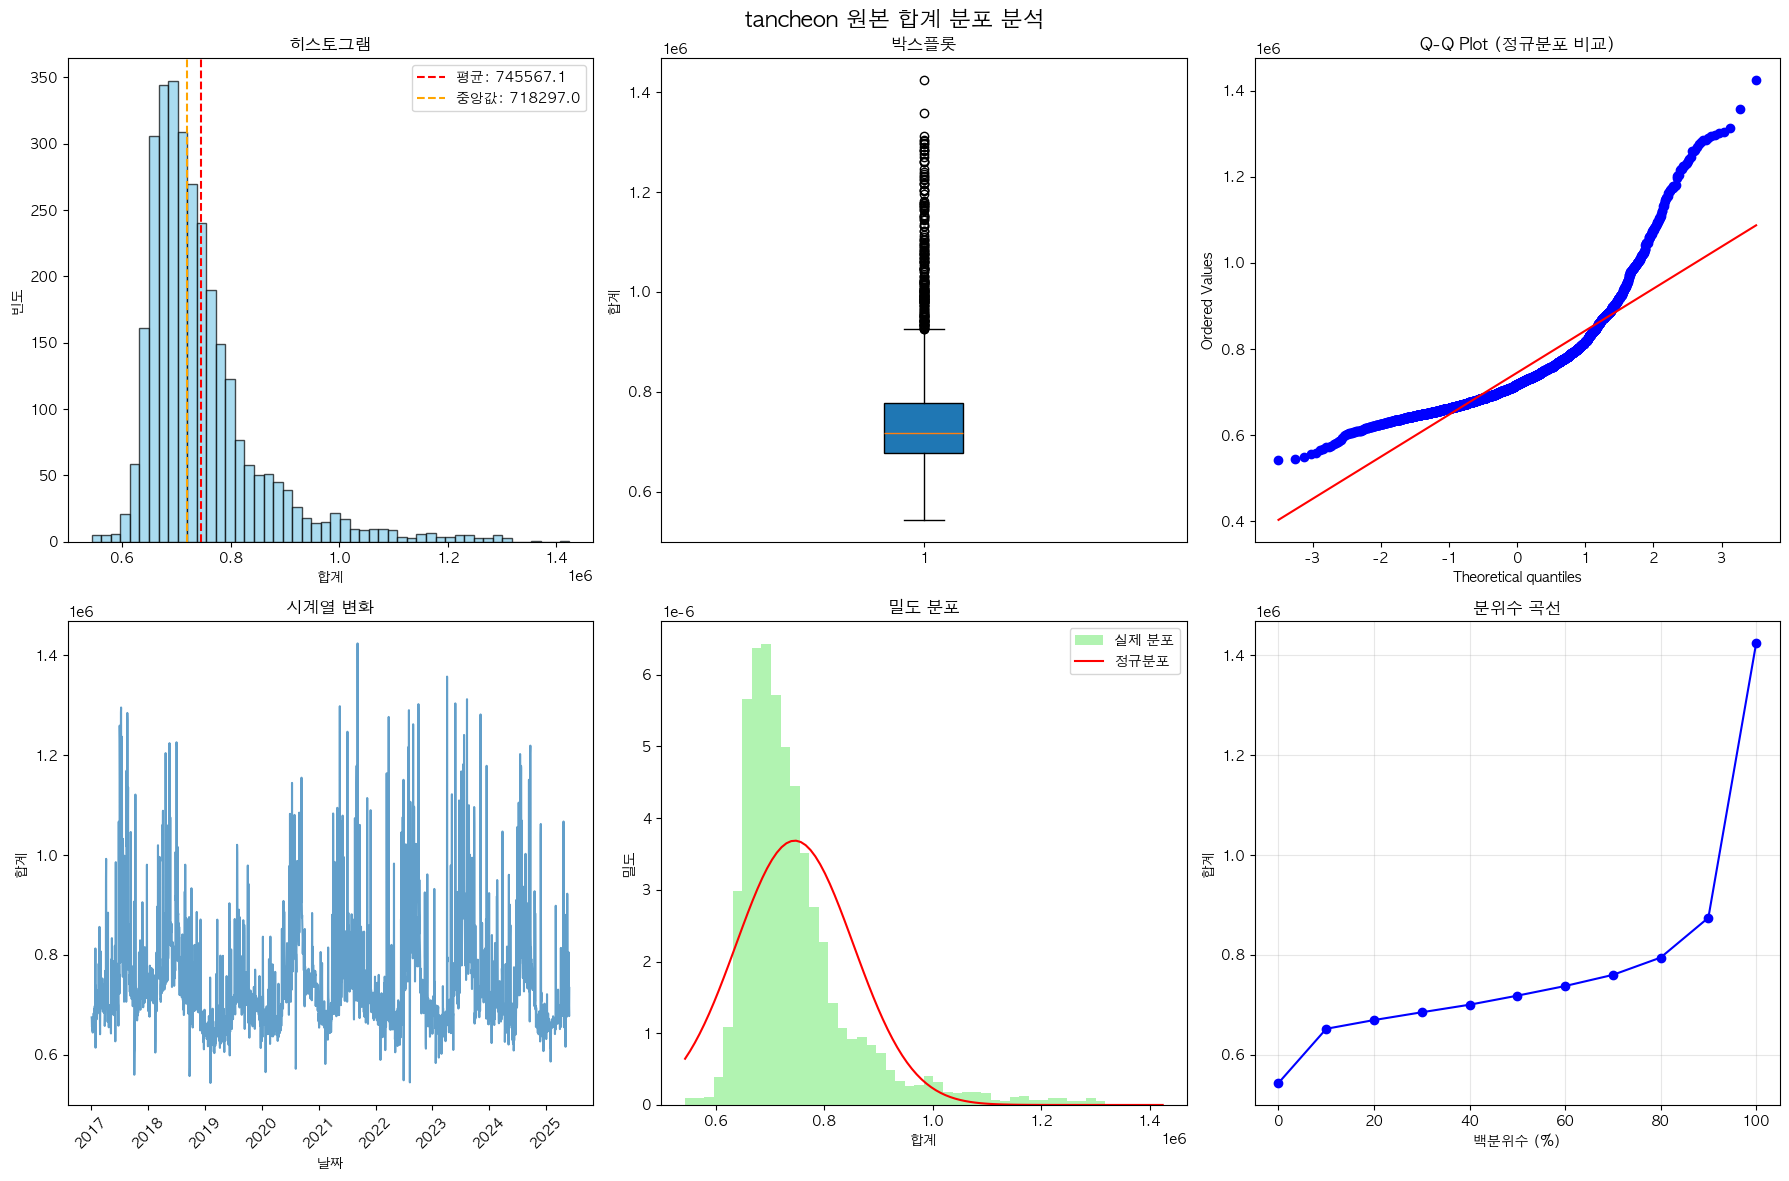

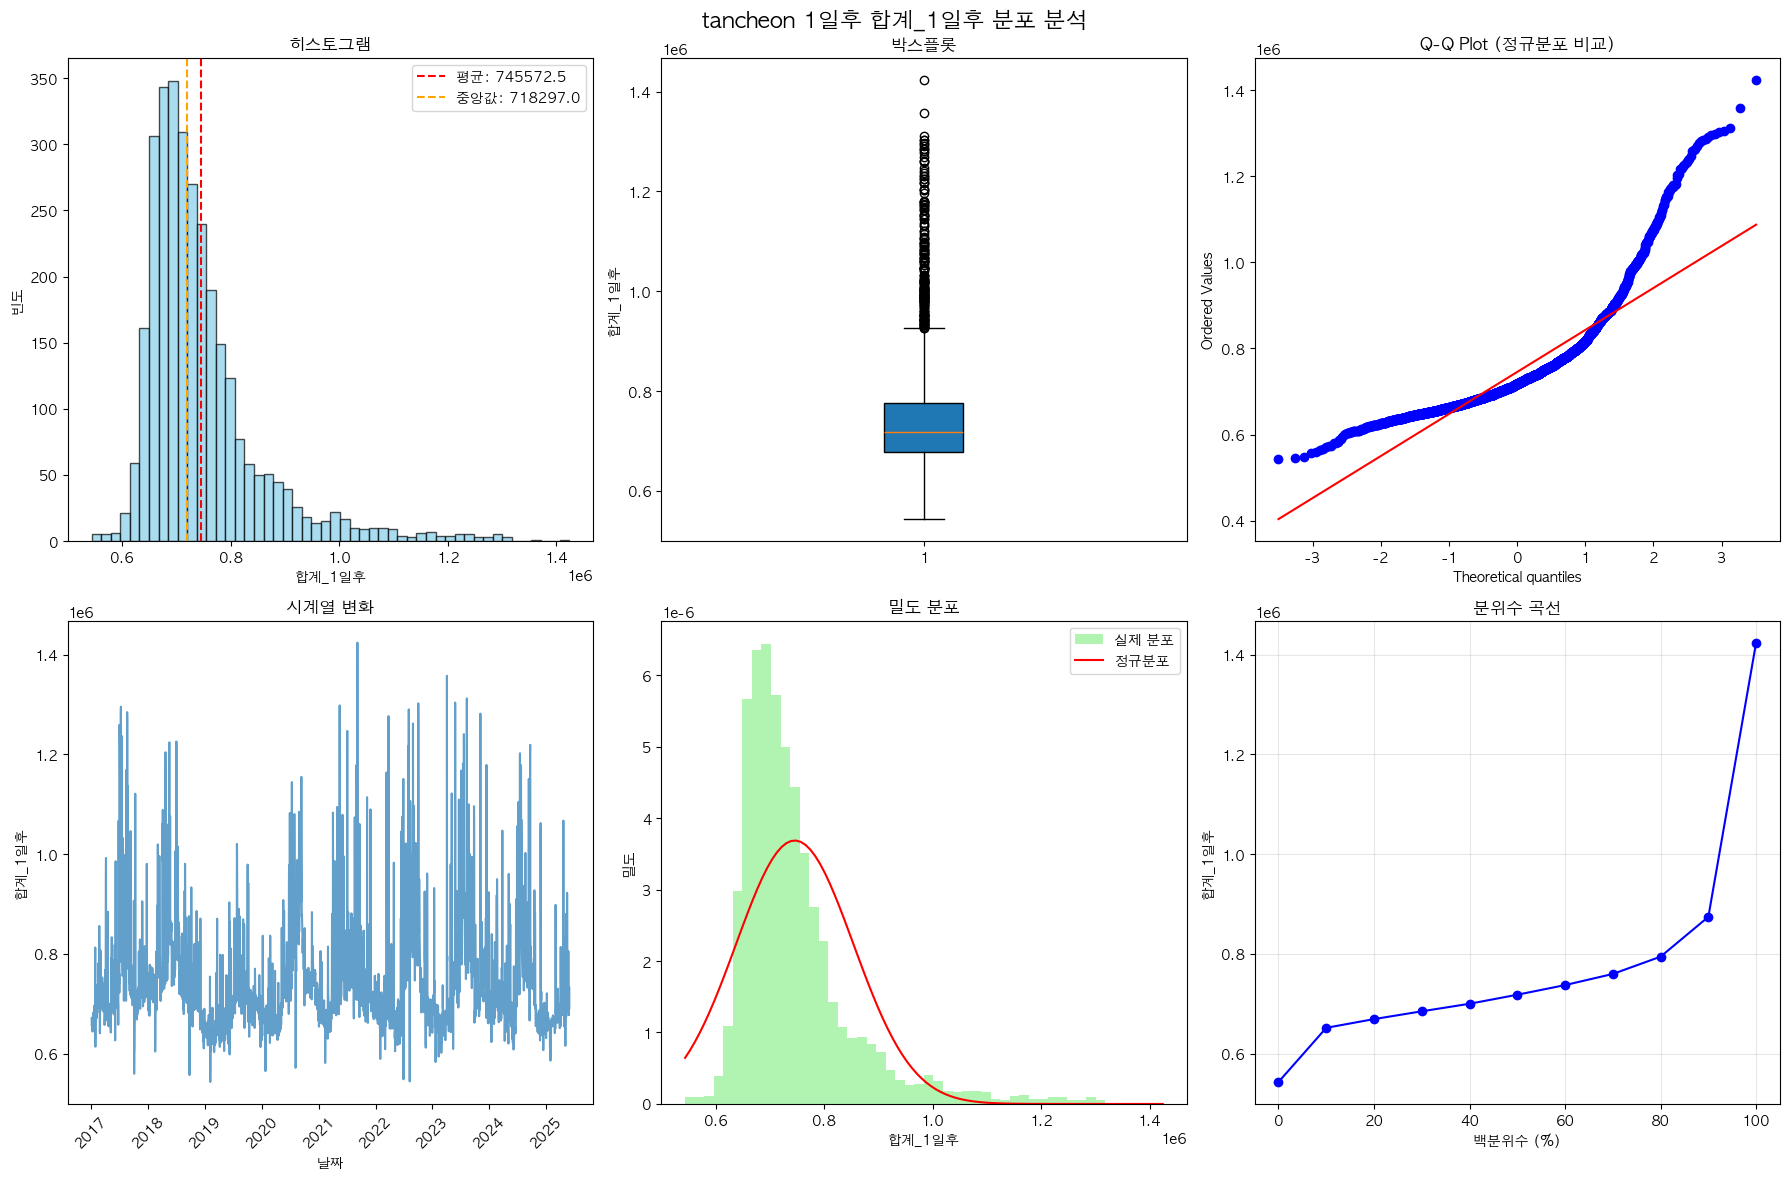


=== tancheon 1일후 클래스 수별 분류 난이도 ===
q: 요청 클래스 수, actual: 실제 클래스 수, balance: 균형도(높을수록 좋음)
cv: 변동계수(낮을수록 균등), entropy: 정규화 엔트로피(높을수록 균등)
theor_acc: 이론적 랜덤 정확도
 q  actual  balance    cv  entropy  theor_acc
 3       3    1.000 0.000      1.0      0.333
 4       4    0.999 0.001      1.0      0.250
 5       5    0.998 0.001      1.0      0.200
 6       6    0.998 0.001      1.0      0.167
 7       7    0.998 0.001      1.0      0.143
 8       8    0.997 0.001      1.0      0.125
 9       9    1.000 0.000      1.0      0.111
10      10    0.997 0.001      1.0      0.100
11      11    1.000 0.000      1.0      0.091


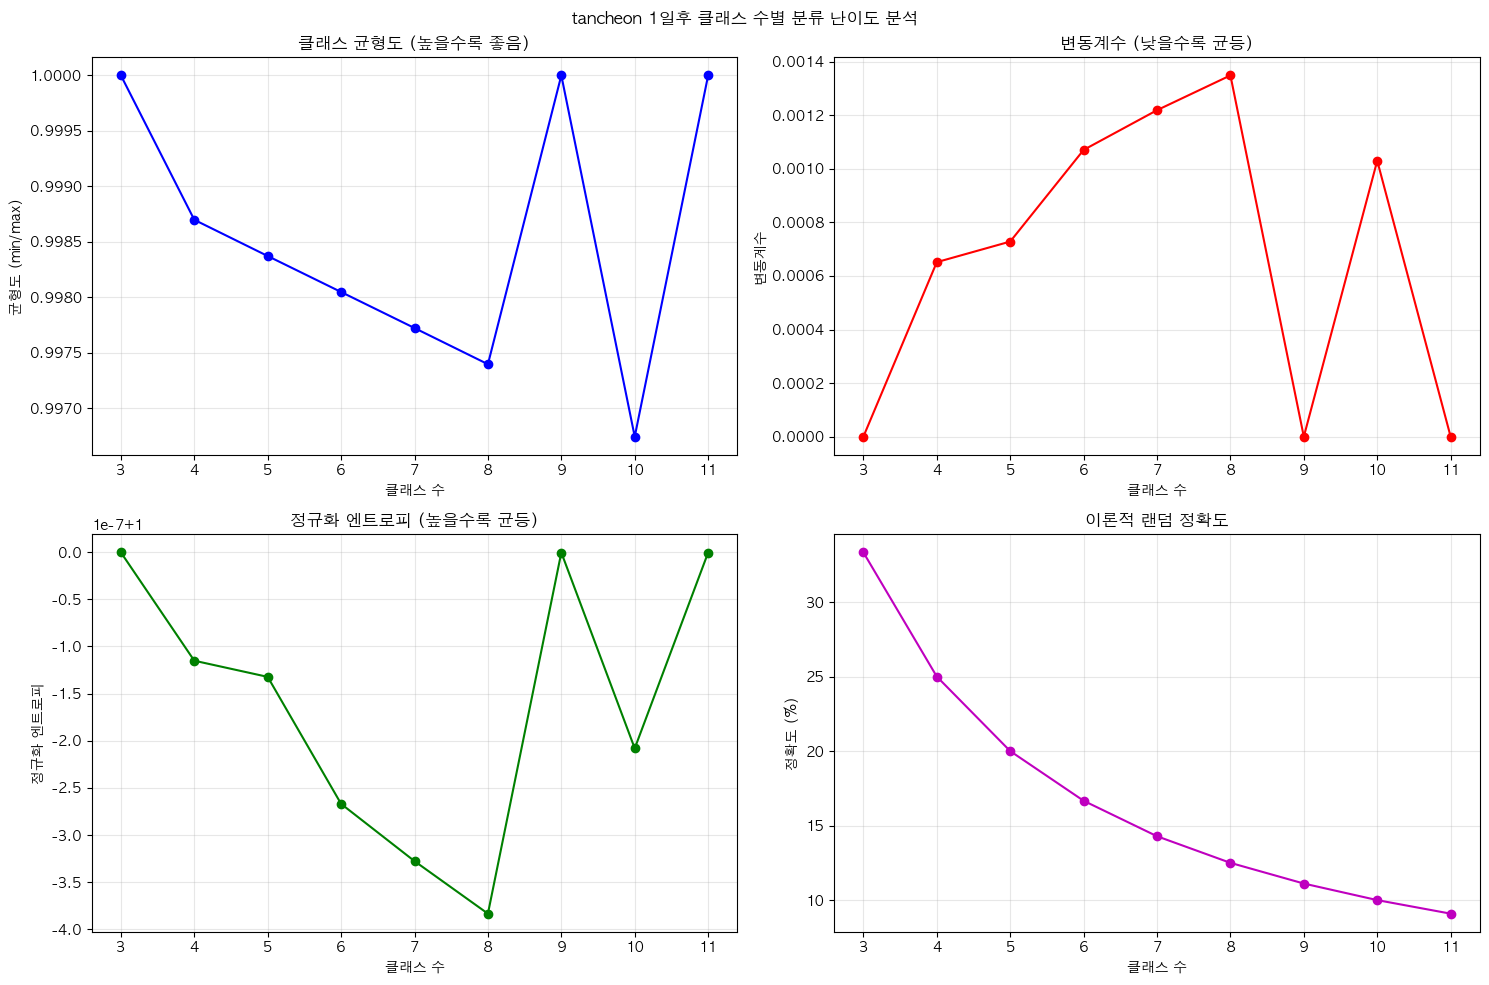


추천 클래스 수: 3개 (엔트로피 기준)

=== 센터별 비교 요약 ===
                mean        std     median        min        max  skewness  \
nanji      603962.90  133044.20   556452.0   442332.8  1381444.0      2.42   
jungnang  1279005.85  196412.61  1222238.0   625472.0  2745792.0      2.41   
seonam    1576757.80  238566.16  1504241.0  1160337.0  2780034.0      2.11   
tancheon   745572.49  108227.70   718297.0   543425.0  1423827.0      2.15   

          kurtosis  outlier_count  outlier_ratio  
nanji         6.58          353.0           0.12  
jungnang      8.52          290.0           0.09  
seonam        4.64          362.0           0.12  
tancheon      6.19          193.0           0.06  


In [21]:
# 현재 로드된 데이터로 종합 분석
centers_dict = {
    "nanji": nanji_processed,
    "jungnang": jungnang_processed, 
    "seonam": seonam_processed,
    "tancheon": tancheon_processed
}

# 전체 분석 (시간이 걸릴 수 있음)
all_stats = comprehensive_target_analysis(centers_dict)